# What Can We Learn From Three Million IRA Tweets?

A while back, FiveThirtyEight released a dataset of just about three million tweets from the Russian troll farm known as the Internet Research Agency (IRA) dating from early 2016 to June of 2018. I wanted to see what exactly I could figure out from these tweets. Twitter has since released a massive nine million tweet dataset dating back to 2009 or so, and I may look at it in the future, but for now I am more interested in this specific set and the relevance it has to the 2016 United States presidential election.

The tweets are available at https://github.com/fivethirtyeight/russian-troll-tweets/ and all code used in this notebook is available at https://github.com/ben-hardy/threemilliontweets/. I'll also have a script that will set up all of the data available to make thing simple should you want to mess with the tweets yourself.

## Studying The Data

Before we get to any code, we have to look at the data itself to see how it is formatted. Looking at the 13 files provided, we can see that they are Comma-Separated Values (CSV) files with over 20 columns and over 100,000 rows of data. The columns include headings such as the name of the account that posted, the Twitter account number, the content of the post, the number of followers the account has, and the number of people they follow. Also included are where any the locations any links in a tweet point to, but we aren't as interested in that as compared to the content of the tweets themselves. FiveThirtyEight also did some rudementary classification, giving indications such as if a tweets was a retweet or not (more on that later), whether an account was considered a right-wing troll account, left-wing troll account, or other, and what language a tweet was.

## Getting Started

First, we will need to cut down the data a bit. The dataset is roughly 2.9 million tweets, but only closer to 1.15 million of the tweets are actual partisan troll tweets. So we will use common tools like Pandas to simplify the set down to this 1.15 million tweets.

I highly recommend using a virtual environment for downloading and using all of the libraries we will be working with. I will include a bash script in the GitHub repo to help with installation and setup of the virtual environment and all of the libraries we are going to use. There are also many tutorials online that can help with installation of Pandas and the like using pip or setup_tools.

In [5]:
import pandas as pd
import numpy as np
import pandasql
import matplotlib.pyplot as plt
import os
import scipy.stats
import spacy
from multiprocessing import Process
from time import sleep
from time import time
from scipy.stats import ttest_ind

from textblob import TextBlob

import string
import re
import random

Now that the formalities are out of the way, it's time to get to work. Firstly, I moved all of the tweet CSVs from their default directory they come in from GitHub to one simply called "tweets". Now we will go through each file, create a dataframe out of the tweets, and then filter out everything we don't want before appending it to a newly created CSV. To start with, we simply want all tweets that are English language. We will then filter them by type, splitting up the tweets into a dataframe of left-wing tweets and another of right-wing tweets. We finally add the tweets to two CSVs stored in a directory called "csv". The two CSVs are called left_tweets and right_tweets. 

Since we are working with all of the tweets at this moment, we will also keep a tally of the number of tweets, and how they break down into the categories we are looking at.

In [6]:
if not ('righttweets.csv' in os.listdir('./csv/') and 'lefttweets.csv' in os.listdir('./csv/')):
    first = True

    # Read in the file names for the tweets. Change tweet_dir to where you have the tweets stored
    tweet_dir = './tweets/'
    files = sorted(os.listdir('./tweets/'))
    if 'README.md' in files:    
        files.remove('README.md')

    # we will use these to keep track of the numbers of each type of tweets
    total_tweet_count = 0
    lw_tweet_count = 0
    rw_tweet_count = 0
    russian_tweet_count = 0
    
    for f in files:
        #print("Working on {}".format(f))
        raw_tweets = pd.read_csv(tweet_dir + f)
        total_tweet_count += len(raw_tweets)
        russian_tweet_count += len(raw_tweets.query('language == "Russian"'))
        english_tweets = raw_tweets.query('language == "English"')
        tweets_no_extra = pd.DataFrame()
        tweets_no_extra['content'] = english_tweets['content'].values
        # we have to use fillna since by default the post type column only is used to indicate retweets
        tweets_no_extra['post_type'] = english_tweets['post_type'].fillna('TWEET')
        tweets_no_extra['account_type'] = english_tweets['account_type'].values
        tweets_no_extra['account_category'] = english_tweets['account_category'].values
        tweets_no_extra['followers'] = english_tweets['followers'].values
        tweets_no_extra['following'] = english_tweets['following'].values

        # split the tweets into whether or not they were left or right wing
        english_tweets_no_rts_rwing = tweets_no_extra.query('account_category == "RightTroll"')
        english_tweets_no_rts_lwing = tweets_no_extra.query('account_category == "LeftTroll"')
        if first: # write them
            english_tweets_no_rts_rwing.to_csv('csv/righttweets.csv', index=False)
            english_tweets_no_rts_lwing.to_csv('csv/lefttweets.csv', index=False)
            first = False
        else:
            english_tweets_no_rts_rwing.to_csv('csv/righttweets.csv', index=False, mode='a', header=False)
            english_tweets_no_rts_lwing.to_csv('csv/lefttweets.csv', index=False, mode='a', header=False)
        lw_tweet_count += len(english_tweets_no_rts_lwing)
        rw_tweet_count += len(english_tweets_no_rts_rwing)
        
    other_tweet_count = total_tweet_count - lw_tweet_count - rw_tweet_count - russian_tweet_count
    print("Total Number of Tweets: {}".format(total_tweet_count))
    print("Number of Right Wing English tweets: {}".format(rw_tweet_count))
    print("Number of Left Wing English tweets: {}".format(lw_tweet_count))
    print("Number of Russian tweets: {}".format(russian_tweet_count))
    print("Number of Other Tweets: {}".format(other_tweet_count))

else: 
    print("righttweets.csv and lefttweets.csv already exist! so skipping creating them")


Total Number of Tweets: 2946207
Number of Right Wing English tweets: 704953
Number of Left Wing English tweets: 422141
Number of Russian tweets: 610943
Number of Other Tweets: 1208170


We can see from the previous result, that out of 2.94 million tweets, only around 1.126 million tweets were English troll tweets. The rest are either retweets or tweets that are not classified as partisan, such as news tweets that are actual news reports (there's an entire account dedicated to local news in New York City, for example) or are about topics unrelated to politics completely.  This reinforces the reporting that the IRA's work was as much about amplifying views and infiltrating US community groups as it was sowing disinformation and engaging with users. Also included in this tweet dataset is a substantial number of tweets in Russian. 

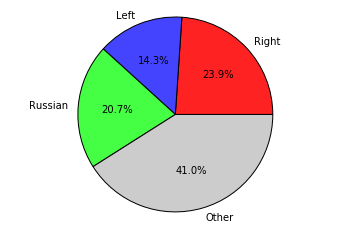

In [7]:
labels = ['Right', 'Left', 'Russian', 'Other']
values = [rw_tweet_count, lw_tweet_count, russian_tweet_count, other_tweet_count]
colours = ['#FF2222', '#4444FF', '#44FF44','#CCCCCC']
wedgeprops={"edgecolor":"#000000",'linewidth': 1, 'linestyle': 'solid', 'antialiased': True}

plt.pie(values, labels=labels, autopct='%1.1f%%', 
        colors=colours, shadow=False, startangle=0, 
        wedgeprops=wedgeprops, frame=False,
        explode=[0,0,0,0])
plt.axis('equal')
plt.show()

The new DataFrames we have created have the following structure:

In [8]:
rw_tweets_filename = './csv/righttweets.csv'
lw_tweets_filename = './csv/lefttweets.csv'

rw_tweets = pd.read_csv(rw_tweets_filename)
lw_tweets = pd.read_csv(lw_tweets_filename)

print(", ".join(rw_tweets.columns.values))

content, post_type, account_type, account_category, followers, following


## Prepping The Tweets

Now that we haved pared down the tweet dataset to a more manageable size, we can study and clean up the tweets themselves to make them somewhat more useful. One observation we can make is that a lot of the tweets have URL-shortened links at the end of them in the form of "https://t.co/blah". This format is how Twitter stores tweets. We can use this to our advantage since we do not care about these links. We can go through each tweet, and if it has a link, we simply chop the link off the end of the tweet. We can do this with the following function:

In [9]:
def trim_tailing_link(tweet):
    result = tweet.split(" ")
    if "https://" in result[-1]:
        return (" ".join(result[0:-1]))
    else:
        return tweet

# apply the function to the tweets using the DataFrame apply function. This may take a few seconds
rw_tweets['content'] = rw_tweets.apply(lambda row: trim_tailing_link(row['content']), axis=1)
lw_tweets['content'] = lw_tweets.apply(lambda row: trim_tailing_link(row['content']), axis=1)

Cool! Now we don't have to worry about links! However, one observation that can be made is that some of the tweets were just links with no other text, so now we may have a small number of tweets with no text in them, so we will have to cull those tweets so it saves us from future pain. This is fairly straightforward to do also. We will simply add a new column to our dataframe with the length of the tweet, and any tweet shorter than a few characters we will filter out:

In [10]:
print("number of RW tweets before culling: {}".format(len(rw_tweets['content'])))
rw_tweets['length'] = rw_tweets.apply(lambda row: len(row['content']), axis=1)
rw_tweets = rw_tweets[rw_tweets['length'] > 5]
print("number of RW tweets after culling: {}".format(len(rw_tweets['content'])))

print("number of LW tweets before culling: {}".format(len(lw_tweets['content'])))
lw_tweets['length'] = lw_tweets.apply(lambda row: len(row['content']), axis=1)
lw_tweets = lw_tweets[lw_tweets['length'] > 5]
print("number of LW tweets after culling: {}".format(len(lw_tweets['content'])))

number of RW tweets before culling: 704953
number of RW tweets after culling: 702767
number of LW tweets before culling: 422141
number of LW tweets after culling: 418939


As we can see, we ended up removing a few thousand tweets from each set, which is good because they were not going to be any use to us anyway. Now we can actually start looking at the content of the tweets themselves!

## Hashtag Usage

One common allegation we see in the media regarding how the IRA operated during and after the 2016 election was that, regardless of party, it focused on stirring up division. They tried to insert themselves into prominent topics and cause people to argue about or doubt things they would previously have accepted as true or false. By stoking up fear and anger, they hoped to motivate certain groups to vote while disenchanting other groups in hopes of tricking them into staying home on Election night. Hashtags are one of the easiest ways to get involved with a conversation, so let's see which hashtags they engaged with the most.

To start, we will do two things: count the number of hashtags present in each tweet, and do a tally of how many times a given hashtag is used.

In [11]:
# Simple function that counts the number of hashtags in a tweet
def count_hashtags(tweet): 
    tweet_word_list = tweet.split(" ")
    hashtag_total = 0
    for word in tweet_word_list:
        if len(word) > 1 and word[0] == '#':
            hashtag_total += 1
    #result = [1 for i in tweet.split(" ") if i[0] == '#']

    return hashtag_total

rw_hashtag_map = {}
lw_hashtag_map = {}

def tally_hashtags(tweet, l_or_r):
    tweet_word_list = tweet.split(" ")

    if l_or_r == 'left':
        for word in tweet_word_list:
            if len(word) > 1 and word[0] == '#':
                if word.lower() in lw_hashtag_map:
                    lw_hashtag_map[word.lower()] += 1
                else:
                    lw_hashtag_map[word.lower()] = 1
    elif l_or_r == 'right':
        for word in tweet_word_list:
            if len(word) > 1 and word[0] == '#':
                if word.lower() in rw_hashtag_map:
                    rw_hashtag_map[word.lower()] += 1
                else:
                    rw_hashtag_map[word.lower()] = 1


# count the number of hashtags in each tweet by using apply to run count_hashtags on all tweets
rw_tweets['hashtag_count'] = rw_tweets.apply(lambda row: count_hashtags(row['content']), axis=1)
lw_tweets['hashtag_count'] = lw_tweets.apply(lambda row: count_hashtags(row['content']), axis=1)

rw_tweets.apply(lambda row: tally_hashtags(row['content'], 'right'), axis=1)
rw_hashtag_sorted_list = sorted(rw_hashtag_map, key=rw_hashtag_map.get, reverse=True)
lw_tweets.apply(lambda row: tally_hashtags(row['content'], 'left'), axis=1)
lw_hashtag_sorted_list = sorted(lw_hashtag_map, key=lw_hashtag_map.get, reverse=True)

print("mean number of hashtags per tweet for right wing: {}".format(np.mean(rw_tweets['hashtag_count'])))
print("mean number of hashtags per tweet for left  wing: {}".format(np.mean(lw_tweets['hashtag_count'])))

print("variance in number of hashtags per tweet for right wing: {}".format(np.var(rw_tweets['hashtag_count'])))
print("variance in number of hashtags per tweet for left wing: {}".format(np.var(lw_tweets['hashtag_count'])))

mean number of hashtags per tweet for right wing: 0.7401528529370331
mean number of hashtags per tweet for left  wing: 0.6446642589971332
variance in number of hashtags per tweet for right wing: 1.5533893776750158
variance in number of hashtags per tweet for left wing: 1.427528351982865


We can see from the data that, on average, the troll accounts used slightly more hashtags when posing as Republicans than as Democrats, but still the number of hashtags used was quite low 

The top 10 right wing hashtags used by the bots are as follows:

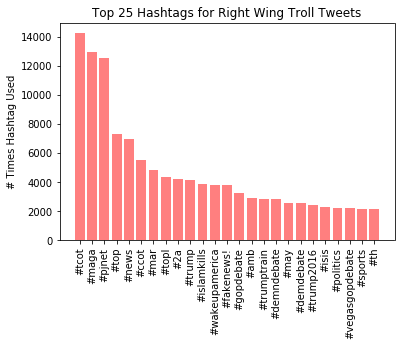

In [12]:
hashtags = [i for i in rw_hashtag_sorted_list[:25]]
hashtag_counts = [rw_hashtag_map[i] for i in hashtags]
y = np.arange(len(hashtags))

plt.bar(y, hashtag_counts, align='center', alpha=0.5, color='#FF0000')
plt.xticks(y, hashtags, rotation=90)
plt.ylabel("# Times Hashtag Used")
plt.title("Top 25 Hashtags for Right Wing Troll Tweets")
plt.show()


And similarly for the Democrats:

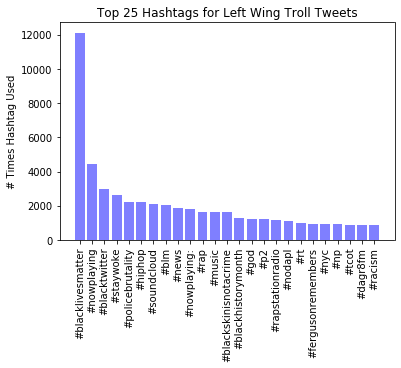

In [13]:
hashtags = [i for i in lw_hashtag_sorted_list[:25]]
hashtag_counts = [lw_hashtag_map[i] for i in hashtags]
y = np.arange(len(hashtags))

plt.bar(y, hashtag_counts, align='center', alpha=0.5, color='#0000FF')
plt.xticks(y, hashtags, rotation=90)
plt.ylabel("# Times Hashtag Used")
plt.title("Top 25 Hashtags for Left Wing Troll Tweets")
plt.show()


Examining the difference between the top hashtags for left-wing tweets and right-wing tweets, we can see a pretty obvious pattern form for each. With the right-wing tweets, the target of the IRA appears to have been to insert themselves into the top hashtags among conservatives such as the well-known "#MAGA" and the older "#TCOT", which is an acronym for "Top Conservatives On Twitter". Both are quite commonly used to this day among conservatives. For the left wing, it appears the approach was more nuanced.

Given that there were approximately 68% more right-leaning tweets than left leaning tweets, the fact that "#blacklivesmatter" was used nearly as often as "#MAGA", that combined with the sheer number of hashtags referring to the African-American population, we can see that the IRA directly targeted African-Americans. In fact, for left-wing tweets, 2.89% of tweets have "#blacklivesmatter" in them, or nearly 3/100 which is much much higher than any of the right-wing hashtags, of which the most used hashtag, "#TCOT", is found in just 2.03% of tweets, or about 2/100.

Another observation is that the IRA tried to get into several other major left-associated hashtags, including "#nodapl", relating to the Dakota Access Pipeline. More prominently though, are references to several different events where unarmed black men were shot by police. We can see the shooting of Michael Brown in Ferguson, Missouri is in the top 25, but also found further down the list are references to Trayvon Martin, Alton Sterling, and Philando Castille. Between all of these references, and the disproportionate number of uses of '#blacklivesmatter', it is abundantly clear that the IRA had set a target on African-American Democrats.


## Sentiment Analysis

One point of interest when comparing the left- and right-wing tweets is to see if, on average, one set was written to be more positive or negative than the other. Of course, there are downsides to sentiment analysis, specifically relating to context, but it still can provide us with at least a bit of a view as to whether or not efforts were put into making one side angrier or more enraged than the other.

To do so, first we will need to clean up the tweets more than we have previously. We will have to remove things like punctuation and emoji. To do so, we can use the following function:

In [14]:
def remove_cruft(tweet):
    words = tweet.split(" ")

    if (words[0]) == "RT":
        words = words[1:]

    if "https://" in words[-1] or "http://" in words[-1]:
        words = words[0:-1]
    
    #remove hashtags, handles, and punctuation
    words = [w for w in words if not ('#' in w) or ('@' in w)]
    words = [w.strip(string.punctuation) for w in words]
    words = list(filter(None, words)) # get rid of empty strings that can result from previous removals

    clean_tweet = " ".join(words)

    # remove emojis. The pattern is from stack exchange because unicode is a hellish nightmare
    reg = re.compile(u'['
    u'\U0001F300-\U0001F64F'
    u'\U0001F680-\U0001F6FF'
    u'\u2600-\u26FF\u2700-\u27BF]+', 
    re.UNICODE)
    clean_tweet = reg.sub(r'', clean_tweet).strip()

    return clean_tweet

We also need a function to do the actual sentiment analysis. We will be using TextBlob's built in sentiment analysis for this. We will be storing the sentiment in various lists:

In [15]:
def analyze_sentiment(tweet):
    blob = TextBlob(tweet)
    return blob.sentiment.polarity

Now that these two functions are established, it's time to use them. We will next use remove_cruft to clean up the tweets. As mentioned before, we can't just used the already used cleaned up tweet CSV because we need to remove punctuation and emoji as well as the links we previously removed. We will do so as follows:

In [16]:
csv_dir = './csv/'

csv_files = os.listdir(csv_dir)

if not('cleaned_lefttweets.csv' in csv_files and 'cleaned_righttweets.csv' in csv_files):
        print('First time running sentiment_analysis.py. Some prep needs to be done before we can start!')
        lw_tweets = pd.read_csv(csv_dir + "lefttweets.csv")
        rw_tweets = pd.read_csv(csv_dir + "righttweets.csv")

        # Similar to in analyze_tweets.py, we will clean the tweets, then remove anything shorter
        # than 5 characters since analyzing sentiment on that short of a sentence is pointless.
        rw_tweets['content'] = rw_tweets.apply(lambda row: remove_cruft(row['content']), axis=1)
        lw_tweets['content'] = lw_tweets.apply(lambda row: remove_cruft(row['content']), axis=1)

        # now that links are removed, we want to get rid of any tweets that were just links since
        # the tweet text will now be empty.
        print("number of RW tweets before culling: {}".format(len(rw_tweets['content'])))
        rw_tweets['length'] = rw_tweets.apply(lambda row: len(row['content']), axis=1)
        rw_tweets = rw_tweets[rw_tweets['length'] > 5]
        print("number of RW tweets after culling: {}".format(len(rw_tweets['content'])))

        print("number of LW tweets before culling: {}".format(len(lw_tweets['content'])))
        lw_tweets['length'] = lw_tweets.apply(lambda row: len(row['content']), axis=1)
        lw_tweets = lw_tweets[lw_tweets['length'] > 5]
        print("number of LW tweets after culling: {}".format(len(lw_tweets['content'])))

        lw_tweets.to_csv(csv_dir + "cleaned_lefttweets.csv", index=False)
        rw_tweets.to_csv(csv_dir + "cleaned_righttweets.csv", index=False)


First time running sentiment_analysis.py. Some prep needs to be done before we can start!
number of RW tweets before culling: 704953
number of RW tweets after culling: 697736
number of LW tweets before culling: 422141
number of LW tweets after culling: 414284


Now that the tweets have been cleaned of emoji, hashtags, links, and twitter handles, it's time to do the actual analysis. Since running the analysis takes a while, and is done in a fairly linear fashion, we can use the multiprocessing library to speed up the analysis by running in on two separate processor threads.

In [17]:
if not('analyzed_lefttweets.csv' in csv_files and 'analyzed_righttweets.csv' in csv_files):
        
        print("Running sentiment analysis on the tweets. This will take a couple minutes at least.")

        # running the two analyses on two different processors so it doesn't take 5 minutes
        def analyze_lw_thread():
            lw_tweets_clean = pd.read_csv(csv_dir + "cleaned_lefttweets.csv")
            lw_tweets_clean['sent_polarity'] = lw_tweets_clean.apply(lambda row: analyze_sentiment(row['content']), axis=1)
            lw_tweets_clean.to_csv(csv_dir + "analyzed_lefttweets.csv")

        def analyze_rw_thread():
            rw_tweets_clean = pd.read_csv(csv_dir + "cleaned_righttweets.csv")
            rw_tweets_clean['sent_polarity'] = rw_tweets_clean.apply(lambda row: analyze_sentiment(row['content']), axis=1)
            rw_tweets_clean.to_csv(csv_dir + "analyzed_righttweets.csv")
        
        t = time()
        p1 = Process(target=analyze_lw_thread)
        p2 = Process(target=analyze_rw_thread)
        p1.start()
        p2.start()
        p1.join()
        p2.join()
        while p1.is_alive() or p2.is_alive():
            sleep(1)
        print("Analysis completed in {} seconds".format(time() - t))


Running sentiment analysis on the tweets. This will take a couple minutes at least.
Analysis completed in 133.85860681533813 seconds


Now that the sentiment analysis itself is done, we can start doing some comparisons to see whether or not the IRA wrote tweets with differing levels of hostility based on who they were talking about. For TextBlob's sentiment analysis Polarity score, scores below 0 are regarded as negative sentiment, above 0 positive, and around 0 neutral.

First, before we go any deeper into certain topics mentioned in the tweets, we will simply look at how the left-wing and right-wing tweets overall scored. First we need to load up the analyzed tweets, which we previously made CSVs of. We can then use NumPy to easily find the mean scores like so:

In [18]:
lw_tweets = pd.read_csv(csv_dir + "analyzed_lefttweets.csv")
rw_tweets = pd.read_csv(csv_dir + "analyzed_righttweets.csv")

print('Polarity for left-wing tweets: {}'.format(np.mean(lw_tweets['sent_polarity'])))
print('Polarity for right-wing tweets: {}'.format(np.mean(rw_tweets['sent_polarity'])))

Polarity for left-wing tweets: 0.06698511405485429
Polarity for right-wing tweets: 0.03460235277682819


The first observation to make is that both means are quite close to 0. They are both less than a tenth positive. However, if you take a peek at the CSVs of tweets paired with sentiment scores, you will observe that a significant number of tweets have scores of either 0 quite close to 0. This could be due to many things. Tweets in general were restricted to 140 characters at this time, so not a lot could be said in any individual tweet. Sentiment analysis also can miss contextual sentiment. For example, the name "Hillary Clinton" may have negative sentiment for some while positive sentiment for others. This can be fine-tuned for, but we are just looking at a rough overall picture.

Something we can quickly observe though, is that despite both mean scores being close to 0, the left-wing score is nearly twice the right-wing score. This seems like a big difference. We can do some basic statistical analysis to confirm the significance of this difference. To do so, we will take a sample of 10000 tweets from each, and run a basic statistical t-test to see. The null hypothesis in this case will be that the sentiment polarity of the two samples of tweets are not significantly different. For those of you uncomfortable with stats, the number to look at is the p-value. Typically, a p-value below 0.05 is considered significant. In this context that would mean that one sample of tweets has significantly different sentiment polarity scores than the other sample. We can run the test like so:

In [23]:
lw_polarity = lw_tweets['sent_polarity'].values
rw_polarity = rw_tweets['sent_polarity'].values

lw_population_sample = random.sample(range(len(lw_tweets)), 10000)
rw_population_sample = random.sample(range(len(rw_tweets)), 10000)

lw_sample_polarity = [lw_polarity[i] for i in lw_population_sample]
rw_sample_polarity = [rw_polarity[i] for i in rw_population_sample]

print('\nTest to see if polarity in sample of LW tweets is significantly different than RW tweets')
t, p = ttest_ind(lw_sample_polarity, rw_sample_polarity, equal_var=False)
print('t-value: {}\np-value: {}'.format(t, p))

if p < 0.05:
    print("Reject Null Hypothesis; the left-wing tweets have significantly different polarity than the right-wing tweets")
else: print ("Do not reject Null Hypothesis: Polarity is not significantly different among tweets")


Test to see if polarity in sample of LW tweets is significantly different than RW tweets
t-value: 7.736725271078683
p-value: 1.0684995136473118e-14
Reject Null Hypothesis; the left-wing tweets have significantly different polarity than the right-wing tweets


As we can see above, the p-value is not even remotely close to 0.05, meaning that our suspicions above regarding the difference in the two means is justified. It does appear that when tweeting as Republicans, the IRA tended to submit content that was more negative.

Next, we will be comparing right-wing tweets mentioning Hillary Clinton with those mentioning Donald Trump. We also will compared the Hillary tweets with general right-wing tweets to see if they are any different from a sentimental perspective.

First, we need to find the tweets mentioning Hillary Clinton. We can do so like so:

In [24]:
 hillary_tweets = []
hillary_polarity = []

def find_hillary (tweet, polarity):
    if "hillary" in tweet.lower() or "clinton" in tweet.lower():
        hillary_tweets.append(tweet)
        hillary_polarity.append(polarity)
        return True
    return False
rw_copy = rw_tweets
rw_to_remove = rw_copy.apply(lambda row: find_hillary(row['content'], row['sent_polarity']), axis=1)
to_remove = []
for i in range(len(rw_copy)):
    if rw_to_remove[i]:
        to_remove.append(i)
rw_copy.drop(to_remove, inplace=True)


print('\nNumber of Hillary Clinton-related tweets: {}'.format(len(hillary_tweets)))
print('Average Polarity for Hillary Clinton-related tweets: {}'.format(np.mean(hillary_polarity)))


Number of Hillary Clinton-related tweets: 43055
Average Polarity for Hillary Clinton-related tweets: 0.01815155414147733


We will do basically the same thing for tweets mentioning Trump:

In [25]:
donald_tweets = []
donald_polarity = []

def find_donald (tweet, polarity):
    if "donald" in tweet.lower() or "trump" in tweet.lower():
        donald_tweets.append(tweet)
        donald_polarity.append(polarity)

rw_tweets.apply(lambda row: find_donald(row['content'], row['sent_polarity']), axis=1)

print('\nNumber of Donald Trump-related tweets: {}'.format(len(donald_tweets)))
print('Average Polarity for Donald Trump-related tweets: {}'.format(np.mean(donald_polarity)))


Number of Donald Trump-related tweets: 116428
Average Polarity for Donald Trump-related tweets: 0.029486749218004062


We can see several notable things from the above two results. Firstly, when posting as right-wing folks, the IRA tweeted about Trump far more than they did Clinton; more than twice as often. We can also see that on average, they were more positive when tweeting about Trump, though given how close both averages are to 0, it wasn't that much more positive.

We can do a quick test to see if these two results are statistically significant:

In [36]:
h_random_tweet_selection = random.sample(range(len(hillary_polarity)), 10000)
d_random_tweet_selection = random.sample(range(len(donald_polarity)), 10000)

hillary_sample_polarity = [hillary_polarity[i] for i in h_random_tweet_selection]
donald_sample_polarity = [donald_polarity[i] for i in d_random_tweet_selection]

t, p = ttest_ind(hillary_sample_polarity, donald_sample_polarity, equal_var=False)
print('\nTest to see if tweets mentioning Hillary Clinton are significantly different in terms of polarity than Donald Trump')
print('t-value: {}\np-value: {}'.format(t, p))



Test to see if tweets mentioning Hillary Clinton are significantly different in terms of polarity than Donald Trump
t-value: -3.1514170580924916
p-value: 0.0016272082643165907


We can see here that the test did show as significant, but an observation I made in testing it is that the p-value can vary drastically. I had one or two tests where the value actually surpassed 0.05 and others where it was as small as the p-value in the first test we did. To resolve this lack of clarity, I decided to run the test a large number of times to see what the p-value would average to over many tests. The results were: 

In [38]:
p_list = []

for i in range(10000):
        h_random_tweet_selection = random.sample(range(len(hillary_polarity)), 10000)
        d_random_tweet_selection = random.sample(range(len(donald_polarity)), 10000)

        hillary_sample_polarity = [hillary_polarity[i] for i in h_random_tweet_selection]
        donald_sample_polarity = [donald_polarity[i] for i in d_random_tweet_selection]

        t, p = ttest_ind(hillary_sample_polarity, donald_sample_polarity, equal_var=False)
        p_list.append(p)

print("mean p-value over 10000 tests: {}", np.mean(p_list))

mean p-value over 10000 tests: {} 0.03803812899908741


As we can see, the average p-value for 10000 tests was low enough to be significant, but not ultimately that far below 0.05, so while we can conclude that the sentimentality of tweets mentioning Trump is significantly different than that of Clinton, they aren't all too far off each other.

Next, we will compare the tweets mentioning Hillary Clinton to the general population of right-wing tweets. Given the mean polarity for right-wing tweets is even higher than that of tweets mentioning Trump, this test should be more definitive:

In [41]:
t, p = ttest_ind(hillary_sample_polarity, rw_sample_polarity, equal_var=False)
print('\nTest to see if tweets mentioning Hillary Clinton are significantly different in terms of polarity than random RW tweets')
print('t-value: {}\np-value: {}'.format(t, p))


Test to see if tweets mentioning Hillary Clinton are significantly different in terms of polarity than random RW tweets
t-value: -5.083487722868143
p-value: 3.7391870225094993e-07


As expected, the p-value for this test is much smaller, confirming our suspicion that tweets mentioning Hillary Clinton are indeed significantly different from a sentiment perspective. Given how much lower the mean was for Hillary Clinton tweets, we can confirm that the IRA tended to be more negative when tweeting about Hillary Clinton compared to general right-wing topics.

Now we will shift over to examining the tweets classified as being left-wing. We will do similar tests to those we did before and see how the results differ.

In [42]:
hillary_tweets_lw = []
hillary_polarity_lw = []

def find_hillary2 (tweet, polarity):
    if "hillary" in tweet.lower() or "clinton" in tweet.lower():
        hillary_tweets_lw.append(tweet)
        hillary_polarity_lw.append(polarity)

lw_tweets.apply(lambda row: find_hillary2(row['content'], row['sent_polarity']), axis=1)
print('\nNumber of LW Hillary Clinton-related tweets: {}'.format(len(hillary_tweets_lw)))
print('Average Polarity for LW Hillary Clinton-related tweets: {}'.format(np.mean(hillary_polarity_lw)))


Number of LW Hillary Clinton-related tweets: 4700
Average Polarity for LW Hillary Clinton-related tweets: 0.04334685146926978


We can see several immediate items of note upon filtering out tweets mentioning Hillary Clinton. The most obvious is that she is simply not mentioned very often. She is mentioned exactly 4700 times out of 414284, or in just over 1/100 tweets. She was mentioned nearly ten times more frequently in right-wing tweets. Also of note is that the average sentiment for tweets mentioning her is roughly 66% that of generic left-wing tweets. Given this, it's reasonable to hypothesize that when talking about Hillary Clinton in tweets targeting left-wing Twitter users, the IRA was much more negative. We can confirm this with a simple t-test. Note that we had previously been using larger samples sizes of roughly 10000 to make up for the sheer number of tweets with a sentiment polarity score of zero. We can't do that here so we will simply use the entire population of Clinton-related left-wing tweets versus the same number of tweets from the general population of left-wing tweets.

In [54]:
h_random_tweet_selection = random.sample(range(len(hillary_polarity_lw)), len(hillary_polarity_lw))
lw_random_tweet_selection = random.sample(range(len(lw_polarity)), len(hillary_polarity_lw))

h_sample_polarity = [hillary_polarity_lw[i] for i in h_random_tweet_selection]
lw_sample_polarity = [lw_polarity[i] for i in lw_random_tweet_selection]

print('\nTest to see if tweets mentioning Hillary Clinton are significantly different in terms of polarity than random LW tweets')
t, p = ttest_ind(h_sample_polarity, lw_sample_polarity, equal_var=False)    
print('t-value: {}\np-value: {}'.format(t, p))


Test to see if tweets mentioning Hillary Clinton are significantly different in terms of polarity than random LW tweets
t-value: -4.826621391587382
p-value: 1.4105908092722755e-06


As we can see, our suspicions were definitely confirmed. Given the p-value is that tiny, there is no doubt that left-wing tweets mentioning Hillary Clinton were significantly different in terms of sentimentality than generic tweets. This result lends credence to the media claim that the IRA's goal among Democrats was to not inflame tensions, but to suppress enthusiasm and lower support for Hillary Clinton as a candidate.

Finally, we will do the same thing with Donald Trump and the set of left-wing tweets.

In [48]:
donald_tweets_lw = []
donald_polarity_lw = []

def find_donald2 (tweet, polarity):
    if "donald" in tweet.lower() or "trump" in tweet.lower():
        donald_tweets_lw.append(tweet)
        donald_polarity_lw.append(polarity)

lw_tweets.apply(lambda row: find_donald2(row['content'], row['sent_polarity']), axis=1)
print('\nNumber of LW Donald Trump-related tweets: {}'.format(len(donald_tweets_lw)))
print('Average Polarity for LW Donald Trump-related tweets: {}'.format(np.mean(donald_polarity_lw)))


Number of LW Donald Trump-related tweets: 25070
Average Polarity for LW Donald Trump-related tweets: 0.03139792317350974


Rather curiously, we can see that Trump was talked about substantially more than Clinton was in the left-wing tweet set; over five times more as a rough estimate. As one would expect, sentiment polarity is even lower among tweets referencing Donald Trump than either those referencing Clinton or just in general. We can easily confirm this suspicion:

In [57]:
d_random_tweet_selection = random.sample(range(len(donald_polarity_lw)), 10000)
lw_random_tweet_selection = random.sample(range(len(lw_polarity)), 10000)

d_sample_polarity = [donald_polarity_lw[i] for i in d_random_tweet_selection]
lw_sample_polarity = [lw_polarity[i] for i in lw_random_tweet_selection]

print('\nTest to see if tweets mentioning Donald Trump are significantly different in terms of polarity than random LW tweets')
t, p = ttest_ind(d_sample_polarity, lw_sample_polarity, equal_var=False)    
print('t-value: {}\np-value: {}'.format(t, p))


Test to see if tweets mentioning Donald Trump are significantly different in terms of polarity than random LW tweets
t-value: -8.487891851412657
p-value: 2.2489416705242634e-17


As we can see with this absolutely miniscule p-value, when tweeting about Trump as left-wingers, the IRA was more negative than in general. This was what we expected so it isn't a major shock.

## Conclusion